In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print(tf.__version__)

2.3.0


In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


## Data from Kaggle

https://www.kaggle.com/namanj27/ner-dataset


In [3]:
raw_data = pd.read_csv('/content/drive/My Drive/dat390_data/ner_datasetreference.csv', encoding = "ISO-8859-1")
raw_data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
data = raw_data
from itertools import chain
tok2idx = {}
idx2tok = {}
vocab = list(set(data['Word'].to_list()))
idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
data['Word_idx'] = data['Word'].map(tok2idx)


tok2idx = {}
idx2tok = {}
tags = list(set(data['Tag'].to_list()))
idx2tag = {idx:tok for  idx, tok in enumerate(tags)}
tag2idx = {tok:idx for  idx, tok in enumerate(tags)}
data['Tag_idx'] = data['Tag'].map(tag2idx)

In [5]:
data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,9633,13
1,NaN,of,IN,O,19193,13
2,NaN,demonstrators,NNS,O,6281,13
3,NaN,have,VBP,O,14731,13
4,NaN,marched,VBN,O,33984,13


In [6]:
n_tags = len(tags)
n_vocab = len(vocab)
n_tags, n_vocab

(17, 35178)

In [7]:
print(tags)

['B-geo', 'I-tim', 'B-nat', 'I-gpe', 'B-art', 'B-eve', 'I-eve', 'I-geo', 'B-org', 'I-nat', 'B-per', 'I-per', 'I-org', 'O', 'B-gpe', 'B-tim', 'I-art']


In [8]:
data_fillna = data.fillna(method='ffill', axis=0)
data_sentences = data_fillna.groupby(['Sentence #'], as_index=False
                                )['Word', 'POS', 'Tag', 'Word_idx', 
                                  'Tag_idx'].agg(lambda x: list(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [9]:
' '.join(data_sentences.iloc[0]['Word'])

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [10]:
inputs = np.array(data_sentences['Word_idx'])
targets = np.array(data_sentences['Tag_idx'])
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, padding='post', truncating='post', value= tag2idx["O"])

In [11]:
input_len = len(inputs[0])

In [12]:
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_targets, test_targets = train_test_split(inputs, targets, test_size=0.1, random_state=42)

In [13]:
train_inputs = np.array(train_inputs).reshape(len(train_inputs), 104, 1)
train_targets = np.array(train_targets)
test_inputs = np.array(test_inputs).reshape(len(test_inputs), 104, 1)
test_targets = np.array(test_targets)

## Building LSTM network

In [25]:
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
tf.random.set_seed(2)

In [26]:
model = Sequential()
model.add(Embedding(input_dim=n_vocab+1, output_dim=8))
model.add(Bidirectional(LSTM(units=8, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))
model.add(Dense(n_tags, activation="relu"))
model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 8)           281432    
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 16)          1088      
_________________________________________________________________
dense_4 (Dense)              (None, None, 17)          289       
Total params: 282,809
Trainable params: 282,809
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(train_inputs, train_targets, batch_size=1000, epochs=20, validation_split=0.3)

Epoch 1/20
31/31 [==============================] - 15s 495ms/step - loss: 0.6469 - accuracy: 0.9353 - val_loss: 0.3427 - val_accuracy: 0.9677
Epoch 2/20
31/31 [==============================] - 15s 477ms/step - loss: 0.3012 - accuracy: 0.9678 - val_loss: 0.2742 - val_accuracy: 0.9677
Epoch 3/20
31/31 [==============================] - 15s 482ms/step - loss: 0.2424 - accuracy: 0.9679 - val_loss: 0.2124 - val_accuracy: 0.9678
Epoch 4/20
31/31 [==============================] - 15s 476ms/step - loss: 0.2122 - accuracy: 0.9680 - val_loss: 0.2030 - val_accuracy: 0.9680
Epoch 5/20
31/31 [==============================] - 15s 480ms/step - loss: 0.2012 - accuracy: 0.9680 - val_loss: 0.1826 - val_accuracy: 0.9679
Epoch 6/20
31/31 [==============================] - 16s 519ms/step - loss: 0.1812 - accuracy: 0.9682 - val_loss: 0.1736 - val_accuracy: 0.9680
Epoch 7/20
31/31 [==============================] - 15s 491ms/step - loss: 0.1746 - accuracy: 0.9683 - val_loss: 0.1667 - val_accuracy: 0.9682

In [28]:
model.evaluate(test_inputs, test_targets)

150/150 [==============================] - 3s 21ms/step - loss: 0.1059 - accuracy: 0.9714


[0.10587110370397568, 0.9713563323020935]

<Figure size 432x288 with 0 Axes>

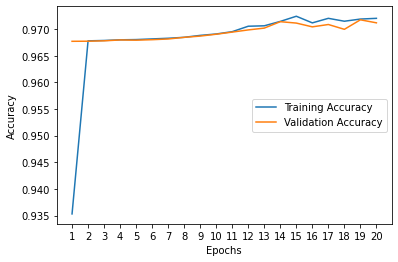

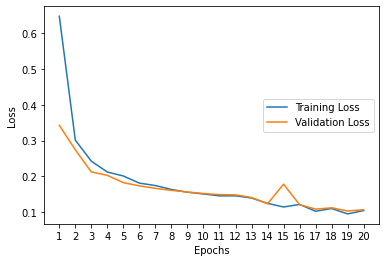

<Figure size 432x288 with 0 Axes>

In [60]:
#------------
# Acc metrics 
#------------
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = np.arange(1, 21)

plt.plot(epochs, acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="center right")
plt.figure()

plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="center right")
plt.figure()

## Refereences:

https://github.com/snehalnair/Named-Entity-Recognition/

https://www.kaggle.com/namanj27/ner-dataset
